# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                        
Sample_113  P01019                                   21.314
Sample_011  O43852;O43852-3;O43852-5                 14.981
Sample_172  Q5T3I4;Q8NCW5;Q8NCW5-2                   15.090
Sample_180  B7Z2R4;C9JR67;O43556;O43556-3;O43556-4   16.732
Sample_037  P23083                                   17.755
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                                                                           
Sample_159  P35968;P35968-2;P35968-3                                                                    15.740
Sample_181  F5GY87;F5GZ38;F5GZH3;F5H0R6;F5H114;F5H1B8;F5H3M1;F5H866;Q9UF11;Q9UF11-2;Q9UF11-3;Q9UF11-4   15.468
Sample_124  Q06033;Q06033-2                                                                             17.106
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.716
            A0A075B6Q5                 13.058
            A0A075B6R2                 12.388
            A0A075B6S5                 13.946
            A0A087WSY4                 11.620
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.925
            Q9UI40;Q9UI40-2            14.247
            Q9UIW2                     12.600
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.959
            Q9UP79                     12.050
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.097,15.050,16.842,19.863,16.106,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.596,19.067,...,15.528,15.576,14.382,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.028,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.962,17.705,17.039,15.777,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.007,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.147,15.345,17.084,18.708,14.249,19.433,11.346,10.400
Sample_207,15.739,16.877,15.469,16.898,13.249,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.716,...,16.012,15.178,11.927,15.050,16.842,19.863,11.248,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.412,19.067,16.188,...,15.528,15.576,11.692,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.693,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.684,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.343,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.936,15.345,17.084,18.708,14.249,19.433,12.429,13.711
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 385.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.93it/s]

100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.99it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

100%|██████████| 4/4 [00:00<00:00,  3.87it/s]

100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.08it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.42it/s]

100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.15it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.51it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.74it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.55it/s]

100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.58it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.57it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.35it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.14it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.96it/s]

100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.66it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.51it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.20it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.02it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.09it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.13it/s]

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.90it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.52it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.11it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.05it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  3.00it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.05it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.03it/s]

100%|██████████| 9/9 [00:02<00:00,  3.13it/s]

100%|██████████| 9/9 [00:02<00:00,  3.21it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.38it/s]

 30%|███       | 3/10 [00:00<00:01,  3.78it/s]

 40%|████      | 4/10 [00:01<00:01,  3.41it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.96it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.90it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.90it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.92it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.84it/s]

100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.11it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.58it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.29it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.15it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.07it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.03it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.71it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.85it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.85it/s]

100%|██████████| 11/11 [00:03<00:00,  2.90it/s]

100%|██████████| 11/11 [00:03<00:00,  3.05it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.87it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.01it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.65it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.45it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.61it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.83it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.82it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.88it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.85it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.53it/s]

100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

100%|██████████| 12/12 [00:04<00:00,  2.74it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.43it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.32it/s]

 31%|███       | 4/13 [00:00<00:02,  3.95it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.92it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.55it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.41it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.48it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.54it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.62it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.66it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.77it/s]

100%|██████████| 13/13 [00:04<00:00,  2.84it/s]

100%|██████████| 13/13 [00:04<00:00,  2.87it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.25it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.28it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.92it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.08it/s]

 43%|████▎     | 6/14 [00:01<00:03,  2.61it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.37it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.41it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.48it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.65it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.72it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.67it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.79it/s]

100%|██████████| 14/14 [00:04<00:00,  2.75it/s]

100%|██████████| 14/14 [00:04<00:00,  2.83it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.34it/s]

 20%|██        | 3/15 [00:00<00:03,  3.82it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.53it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.27it/s]

 40%|████      | 6/15 [00:01<00:02,  3.12it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.52it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.33it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.25it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.24it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.44it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.64it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.80it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.83it/s]

100%|██████████| 15/15 [00:05<00:00,  2.98it/s]

100%|██████████| 15/15 [00:05<00:00,  2.82it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.007      0.081 0.036          0.799 0.303       0.122   
2             0.005 0.004      0.062 0.020          0.709 0.089       0.603   
3             0.006 0.005      0.067 0.026          0.684 0.089       0.618   
4             0.006 0.004      0.069 0.030          0.721 0.082       0.676   
5             0.006 0.004      0.065 0.028          0.701 0.082       0.658   
6             0.007 0.006      0.085 0.023          0.723 0.081       0.699   
7             0.005 0.004      0.061 0.023          0.786 0.082       0.806   
8             0.005 0.003      0.054 0.016          0.793 0.086       0.807   
9             0.004 0.000      0.053 0.019          0.821 0.080       0.819   
10            0.004 0.002      0.048 0.006          0.823 0.079       0.828   
11            0.003 0.001      0.036 0.010          0.830 0.077       0.849   
12            0.004 0.001      0.046 0.012          0.842 0.073       0.835   
13            0.005 0.003      0.054 0.016          0.841 0.075       0.832   
14            0.005 0.003      0.057 0.016          0.838 0.076       0.833   
15            0.006 0.005      0.067 0.023          0.841 0.086       0.822   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.204 0.125                  0.553 0.041        0.858   
2          0.102   0.646 0.079                  0.709 0.058        0.787   
3          0.108   0.644 0.082                  0.703 0.062        0.780   
4          0.106   0.692 0.078                  0.741 0.061        0.800   
5          0.110   0.672 0.074                  0.724 0.053        0.799   
6          0.104   0.705 0.070                  0.749 0.055        0.817   
7          0.111   0.791 0.077                  0.821 0.066        0.906   
8          0.108   0.795 0.076                  0.825 0.065        0.904   
9          0.109   0.817 0.079                  0.844 0.067        0.917   
10         0.107   0.822 0.079                  0.849 0.068        0.917   
11         0.100   0.836 0.073                  0.860 0.063        0.921   
12         0.099   0.836 0.072                  0.860 0.062        0.924   
13         0.099   0.834 0.073                  0.858 0.062        0.923   
14         0.097   0.833 0.073                  0.857 0.063        0.922   
15         0.097   0.827 0.069                  0.852 0.058        0.926   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.830 0.091        210.000 0.000  
2          0.068                  0.763 0.086        210.000 0.000  
3          0.067                  0.754 0.084        210.000 0.000  
4          0.066                  0.768 0.084        210.000 0.000  
5          0.060                  0.761 0.079        210.000 0.000  
6          0.058                  0.791 0.075        210.000 0.000  
7          0.049                  0.884 0.057        210.000 0.000  
8          0.049                  0.880 0.057        210.000 0.000  
9          0.048                  0.904 0.052        210.000 0.000  
10         0.048                  0.904 0.053        210.000 0.000  
11         0.047                  0.914 0.046        210.000 0.000  
12         0.046                  0.916 0.047        210.000 0.000  
13         0.047                  0.915 0.048        210.000 0.000  
14         0.047                  0.914 0.048        210.000 0.000  
15         0.043                  0.918 0.042 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 479.24it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.07it/s]

100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.28it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.28it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.38it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.10it/s]

100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.22it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.01it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.68it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.62it/s]

100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.07it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.29it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.08it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.93it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.74it/s]

100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.44it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.43it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.17it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.27it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.36it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

100%|██████████| 8/8 [00:03<00:00,  2.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.54it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.47it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.29it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.43it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.36it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.31it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.36it/s]

100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.38it/s]

 30%|███       | 3/10 [00:00<00:02,  3.03it/s]

 40%|████      | 4/10 [00:01<00:02,  2.35it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.03it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.04it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.13it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.24it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.35it/s]

100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.76it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.76it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.70it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.29it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.07it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.15it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.27it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.34it/s]

100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.86it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.89it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.30it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.72it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.09it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.11it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.15it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.29it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.38it/s]

100%|██████████| 12/12 [00:04<00:00,  2.43it/s]

100%|██████████| 12/12 [00:04<00:00,  2.50it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.36it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.06it/s]

 31%|███       | 4/13 [00:01<00:02,  3.52it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.15it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.57it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.20it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.18it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.07it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.13it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.24it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.30it/s]

100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

100%|██████████| 13/13 [00:05<00:00,  2.49it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.38it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.23it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.57it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.24it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.07it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.97it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.40it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.21it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.08it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.99it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.06it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.24it/s]

100%|██████████| 14/14 [00:05<00:00,  2.28it/s]

100%|██████████| 14/14 [00:05<00:00,  2.53it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.66it/s]

 20%|██        | 3/15 [00:00<00:02,  4.05it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.57it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.25it/s]

 40%|████      | 6/15 [00:01<00:02,  3.12it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.03it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.17it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.86it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.77it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.92it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.81it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.76it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.82it/s]

100%|██████████| 15/15 [00:04<00:00,  2.88it/s]

100%|██████████| 15/15 [00:04<00:00,  3.05it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.084 0.026          0.321 0.420       0.036   
2             0.006 0.006      0.072 0.027          0.611 0.212       0.263   
3             0.005 0.004      0.061 0.026          0.704 0.105       0.546   
4             0.004 0.002      0.050 0.013          0.690 0.105       0.545   
5             0.003 0.001      0.034 0.009          0.825 0.094       0.790   
6             0.004 0.002      0.045 0.009          0.819 0.091       0.788   
7             0.004 0.002      0.048 0.011          0.795 0.079       0.821   
8             0.005 0.003      0.050 0.009          0.805 0.077       0.834   
9             0.005 0.002      0.049 0.008          0.804 0.082       0.844   
10            0.005 0.003      0.054 0.018          0.807 0.085       0.840   
11            0.004 0.002      0.051 0.015          0.807 0.084       0.842   
12            0.004 0.001      0.062 0.022          0.807 0.085       0.838   
13            0.005 0.003      0.052 0.014          0.804 0.087       0.835   
14            0.005 0.004      0.054 0.015          0.816 0.080       0.844   
15            0.004 0.001      0.046 0.014          0.818 0.076       0.838   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.054   0.063 0.090                  0.513 0.023        0.872   
2          0.138   0.345 0.143                  0.568 0.050        0.721   
3          0.107   0.610 0.091                  0.688 0.065        0.734   
4          0.108   0.605 0.095                  0.683 0.067        0.731   
5          0.100   0.803 0.080                  0.832 0.068        0.913   
6          0.095   0.800 0.077                  0.829 0.065        0.913   
7          0.092   0.804 0.063                  0.831 0.054        0.929   
8          0.103   0.814 0.065                  0.841 0.054        0.929   
9          0.102   0.819 0.068                  0.845 0.058        0.933   
10         0.097   0.819 0.067                  0.845 0.058        0.933   
11         0.103   0.819 0.069                  0.846 0.059        0.933   
12         0.100   0.817 0.069                  0.843 0.058        0.932   
13         0.093   0.814 0.065                  0.841 0.055        0.933   
14         0.092   0.825 0.060                  0.850 0.050        0.934   
15         0.093   0.824 0.060                  0.850 0.050        0.935   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.836 0.087        210.000 0.000  
2          0.101                  0.627 0.122        210.000 0.000  
3          0.068                  0.725 0.080        210.000 0.000  
4          0.068                  0.723 0.081        210.000 0.000  
5          0.047                  0.893 0.058        210.000 0.000  
6          0.048                  0.895 0.058        210.000 0.000  
7          0.036                  0.910 0.045        210.000 0.000  
8          0.038                  0.912 0.043        210.000 0.000  
9          0.039                  0.917 0.045        210.000 0.000  
10         0.038                  0.919 0.043        210.000 0.000  
11         0.038                  0.919 0.043        210.000 0.000  
12         0.039                  0.917 0.044        210.000 0.000  
13         0.038                  0.919 0.043        210.000 0.000  
14         0.037                  0.922 0.042        210.000 0.000  
15         0.036                  0.924 0.040 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 883.38it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.36it/s]

100%|██████████| 3/3 [00:00<00:00, 20.03it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.13it/s]

100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

100%|██████████| 4/4 [00:00<00:00, 12.14it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 17.71it/s]

 80%|████████  | 4/5 [00:00<00:00, 12.06it/s]

100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.56it/s]

100%|██████████| 6/6 [00:00<00:00, 16.80it/s]

100%|██████████| 6/6 [00:00<00:00, 17.41it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 26.61it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 21.47it/s]

100%|██████████| 7/7 [00:00<00:00, 21.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 19.01it/s]

 50%|█████     | 4/8 [00:00<00:00, 12.91it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 12.69it/s]

100%|██████████| 8/8 [00:00<00:00, 13.07it/s]

100%|██████████| 8/8 [00:00<00:00, 13.04it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 14.66it/s]

 44%|████▍     | 4/9 [00:00<00:00, 12.18it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 11.42it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 12.92it/s]

100%|██████████| 9/9 [00:00<00:00, 12.19it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.27it/s]

 60%|██████    | 6/10 [00:00<00:00, 19.42it/s]

 90%|█████████ | 9/10 [00:00<00:00, 20.30it/s]

100%|██████████| 10/10 [00:00<00:00, 18.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 23.73it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.29it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.90it/s]

 91%|█████████ | 10/11 [00:00<00:00, 16.31it/s]

100%|██████████| 11/11 [00:00<00:00, 16.92it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 24.91it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.09it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.68it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 15.22it/s]

100%|██████████| 12/12 [00:00<00:00, 14.54it/s]

100%|██████████| 12/12 [00:00<00:00, 15.27it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.69it/s]

 46%|████▌     | 6/13 [00:00<00:00, 18.75it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 19.86it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 19.71it/s]

100%|██████████| 13/13 [00:00<00:00, 19.81it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 16.54it/s]

 29%|██▊       | 4/14 [00:00<00:00, 14.88it/s]

 43%|████▎     | 6/14 [00:00<00:00, 12.57it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 13.67it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.56it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.52it/s]

100%|██████████| 14/14 [00:01<00:00, 12.90it/s]

100%|██████████| 14/14 [00:01<00:00, 13.22it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 28.45it/s]

 40%|████      | 6/15 [00:00<00:00, 16.25it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 14.25it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.84it/s]

 80%|████████  | 12/15 [00:00<00:00, 10.47it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.65it/s]

100%|██████████| 15/15 [00:01<00:00, 11.29it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.046 0.008          0.000 0.000       0.000   
2             0.004 0.002      0.047 0.012          0.580 0.127       0.453   
3             0.006 0.005      0.070 0.025          0.633 0.111       0.559   
4             0.004 0.002      0.050 0.014          0.665 0.110       0.598   
5             0.005 0.003      0.053 0.015          0.665 0.098       0.617   
6             0.004 0.003      0.054 0.027          0.670 0.107       0.611   
7             0.003 0.003      0.038 0.023          0.691 0.088       0.683   
8             0.004 0.002      0.053 0.019          0.723 0.087       0.703   
9             0.004 0.000      0.047 0.010          0.719 0.085       0.702   
10            0.005 0.004      0.052 0.021          0.715 0.080       0.699   
11            0.006 0.007      0.053 0.012          0.711 0.082       0.691   
12            0.003 0.001      0.035 0.013          0.725 0.079       0.727   
13            0.004 0.003      0.046 0.019          0.710 0.073       0.722   
14            0.005 0.003      0.054 0.019          0.703 0.070       0.720   
15            0.005 0.005      0.050 0.023          0.698 0.074       0.720   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.752   
2          0.109   0.498 0.088                  0.599 0.067        0.697   
3          0.104   0.588 0.092                  0.658 0.070        0.739   
4          0.100   0.624 0.084                  0.685 0.068        0.780   
5          0.100   0.635 0.083                  0.693 0.069        0.799   
6          0.111   0.633 0.087                  0.693 0.071        0.799   
7          0.113   0.680 0.080                  0.727 0.066        0.818   
8          0.119   0.707 0.083                  0.751 0.067        0.830   
9          0.120   0.705 0.084                  0.750 0.069        0.834   
10         0.120   0.701 0.081                  0.747 0.066        0.833   
11         0.128   0.694 0.087                  0.742 0.069        0.828   
12         0.120   0.720 0.078                  0.761 0.065        0.832   
13         0.122   0.711 0.079                  0.753 0.065        0.830   
14         0.120   0.707 0.081                  0.749 0.065        0.826   
15         0.114   0.705 0.077                  0.746 0.063        0.822   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.701 0.087        210.000 0.000  
2          0.079                  0.661 0.068        210.000 0.000  
3          0.081                  0.707 0.085        210.000 0.000  
4          0.069                  0.733 0.082        210.000 0.000  
5          0.065                  0.745 0.080        210.000 0.000  
6          0.064                  0.751 0.077        210.000 0.000  
7          0.058                  0.764 0.072        210.000 0.000  
8          0.056                  0.775 0.071        210.000 0.000  
9          0.056                  0.778 0.066        210.000 0.000  
10         0.056                  0.780 0.065        210.000 0.000  
11         0.056                  0.772 0.066        210.000 0.000  
12         0.060                  0.774 0.072        210.000 0.000  
13         0.062                  0.772 0.081        210.000 0.000  
14         0.062                  0.767 0.079        210.000 0.000  
15         0.063                  0.760 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,1,3
score_time,6,1,3
test_precision,12,5,12
test_recall,11,9,12
test_f1,11,14,12
test_balanced_accuracy,11,14,12
test_roc_auc,15,15,9
test_average_precision,15,15,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.98it/s]

 20%|██        | 3/15 [00:00<00:03,  3.34it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.56it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.16it/s]

 40%|████      | 6/15 [00:02<00:04,  2.08it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.15it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.26it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.35it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.44it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.59it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.74it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.78it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.78it/s]

100%|██████████| 15/15 [00:05<00:00,  2.83it/s]

100%|██████████| 15/15 [00:05<00:00,  2.59it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.91it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.24it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 15.20it/s]

100%|██████████| 9/9 [00:00<00:00, 16.14it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.20it/s]

 20%|██        | 3/15 [00:00<00:02,  4.93it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.27it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.87it/s]

 40%|████      | 6/15 [00:01<00:02,  3.69it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.70it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.51it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.40it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.36it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.43it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.65it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.81it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.91it/s]

100%|██████████| 15/15 [00:03<00:00,  4.12it/s]

100%|██████████| 15/15 [00:03<00:00,  3.87it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


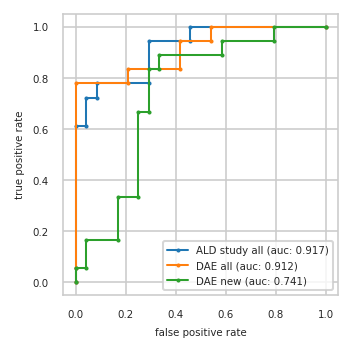

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.611   0.000 0.778   0.042 0.056
3          0.042 0.611   0.208 0.778   0.042 0.167
4          0.042 0.722   0.208 0.833   0.167 0.167
5          0.083 0.722   0.417 0.833   0.167 0.333
6          0.083 0.778   0.417 0.944   0.250 0.333
7          0.292 0.778   0.542 0.944   0.250 0.667
8          0.292 0.944   0.542 1.000   0.292 0.667
9          0.458 0.944   1.000 1.000   0.292 0.833
10         0.458 1.000     NaN   NaN   0.333 0.833
11         1.000 1.000     NaN   NaN   0.333 0.889
12           NaN   NaN     NaN   NaN   0.583 0.889
13           NaN   NaN     NaN   NaN   0.583 0.944
14           NaN   NaN     NaN   NaN   0.792 0.944
15           NaN   NaN     NaN   NaN   0.792 1.000
16           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,A0A087WXB8;Q9Y274,Q9NUQ9
2,P01258;P01258-2;P06881,P02741,E7EPS8;P28827;P28827-2
3,P61981,Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9U...,P31321
4,P14174,P63104,P51688
5,P04075,Q9Y2T3;Q9Y2T3-3,P10644;P10644-2
6,P00338;P00338-3,P04075,O95497
7,C9JF17;P05090,P51688,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,Q9Y2T3;Q9Y2T3-3,P61981,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


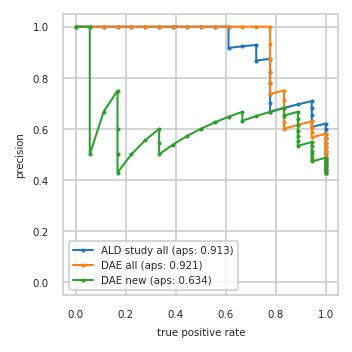

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.630 0.944     0.593 0.889
16         0.654 0.944     0.615 0.889     0.615 0.889
17         0.680 0.944     0.600 0.833     0.640 0.889
18         0.708 0.944     0.625 0.833     0.667 0.889
19         0.696 0.889     0.652 0.833     0.652 0.833
20         0.682 0.833     0.682 0.833     0.682 0.833
21         0.667 0.778     0.714 0.833     0.667 0.778
22         0.700 0.778     0.750 0.833     0.650 0.722
23         0.737 0.778     0.737 0.778     0.632 0.667
24         0.778 0.778     0.778 0.778     0.667 0.667
25         0.824 0.778     0.824 0.778     0.647 0.611
26         0.875 0.778     0.875 0.778     0.625 0.556
27         0.867 0.722     0.933 0.778     0.600 0.500
28         0.929 0.722     1.000 0.778     0.571 0.444
29         0.923 0.667     1.000 0.722     0.538 0.389
30         0.917 0.611     1.000 0.667     0.500 0.333
31         1.000 0.611     1.000 0.611     0.545 0.333
32         1.000 0.556     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


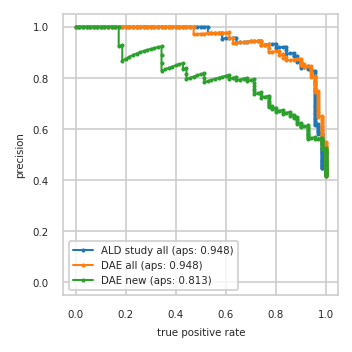

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


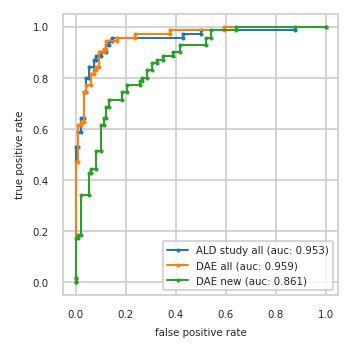

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}